##### Lending Club Data Project

## 4 Model Evaluation: Aplliation to Test Data

Now we evaluate the best model (logistic regression, 10 features) on our test data.

### 4.1 Load Data

In [1]:
reset -fs

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sms
import statsmodels.formula.api as smf

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
import re 
import math

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, mutual_info_classif
pd.set_option('display.max_columns', None)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, confusion_matrix, fbeta_score

In [3]:
X_test = pd.read_csv('x_test_10.csv')
X_test.drop('Unnamed: 0', inplace = True, axis = 1)
y_test = pd.read_csv('y_test.csv')
y_test.drop('Unnamed: 0', inplace = True, axis = 1)

In [4]:
X_train = pd.read_csv('X_smo_10.csv')
y_train = pd.read_csv('y_smo.csv')

In [5]:
X_train.drop('Unnamed: 0', inplace = True, axis = 1)
y_train.drop('Unnamed: 0', inplace = True, axis = 1)

In [6]:
y_train = y_train.rename(columns = {"0": 'loan_status'})

### 4.2 Predict the Test Data with Our Models

#### 4.2.1 Julia's Logistic Regression Model

In [7]:
from sklearn.linear_model import LogisticRegression
best_log_10 = LogisticRegression(C=0.1, class_weight={0: 0.5, 1: 0.5}, l1_ratio=0, max_iter=7812,
                   n_jobs=-1, penalty='elasticnet', random_state=0,
                   solver='saga')
best_log_10.fit(X_train, np.array(y_train).ravel())
y_pred = best_log_10.predict(X_test)

F beta Score for both classes:
0.81


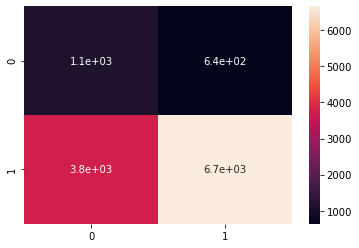

In [8]:
print('F beta Score for both classes:')
print(fbeta_score(y_test, y_pred, beta = .1, average = 'weighted').round(2))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True);

The model generalizes well, the evaluation metric is as good as for the training data.

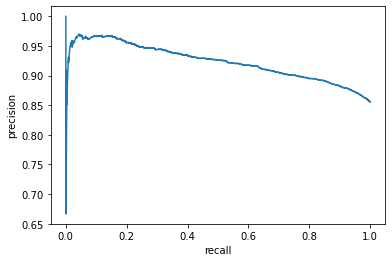

In [9]:
# example of a precision-recall curve for a predictive model
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, best_log_10.predict_proba(X_test)[:,1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

(0.0, 1.0)

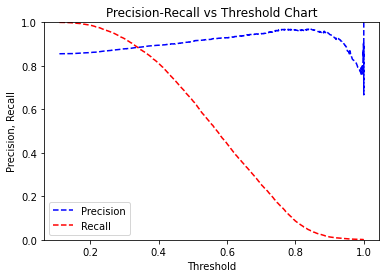

In [10]:
### Predict test_y values and probabilities based on fitted logistic regression model

pred_y = best_log_10.predict(X_test) 

probs_y= best_log_10.predict_proba(X_test) 
 
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 
1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

#### 4.2.2 Marlene's Decision Tree

In [11]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": list(range(1,20,2)),
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              'min_samples_split':list(range(10,500,20)),
              "criterion": ["gini", "entropy"],
            'class_weight': [{0: 0.65,1:0.35}, {0:0.67,1:0.33}, {0:0.69,1:0.31}, {0:0.71,1:0.29}, {0:0.73,1:0.27}, 
                            {0:0.75,1:0.25}, {0:0.77,1:0.23}, {0: 0.79, 1:0.21}]}
# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()
# Instantiate the RandomizedSearchCV object: tree_cv
ftwo_scorer = make_scorer(fbeta_score, beta=0.1, average = "weighted")
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5, scoring=ftwo_scorer, verbose=5, n_jobs=-1)
# Fit it to the data
tree_cv.fit(X_train,y_train)
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))
y_pred = tree_cv.predict(X_test)
fbeta_scorer = fbeta_score(y_test, y_pred, beta=0.1, average = "weighted")
print(f"fbeta: ", fbeta_scorer)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.9s finished


Tuned Decision Tree Parameters: {'class_weight': {0: 0.77, 1: 0.23}, 'criterion': 'gini', 'max_depth': 15, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 30}
Best score is 0.7543485860588337
fbeta:  0.7789578862572094


The model is good but not as good as the logistic regression.

#### 4.2.3 Marlene's Random Forest

In [12]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
# Setup the parameters and distributions to sample from: param_dist
param_rtc= { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'class_weight': [{0: 0.65,1:0.35}]
    }
# Instantiate a Decision Tree classifier: tree
rf = RandomForestClassifier()
# Instantiate the RandomizedSearchCV object: tree_cv
ftwo_scorer = make_scorer(fbeta_score, beta=0.1, average = "weighted")
rf_cv = RandomizedSearchCV(rf, param_rtc, cv=5, scoring=ftwo_scorer, verbose=5, n_jobs=-1)
# Fit it to the data
rf_cv.fit(X_train,y_train)
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))
y_pred = rf_cv.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.3min finished
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Tuned Decision Tree Parameters: {'n_estimators': 500, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'gini', 'class_weight': {0: 0.65, 1: 0.35}}
Best score is 0.7262317469652011


In [13]:
fbeta_scorer = fbeta_score(y_test, y_pred, beta=0.1, average = "weighted")
print(f"fbeta: ", fbeta_scorer)

fbeta:  0.8145729963217873


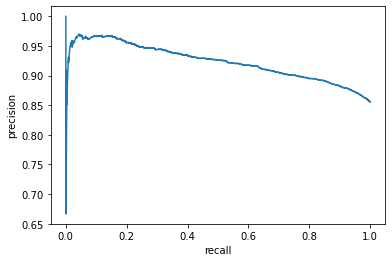

In [14]:
# example of a precision-recall curve for a predictive model
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, best_log_10.predict_proba(X_test)[:,1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

(0.0, 1.0)

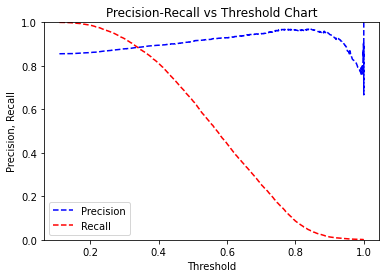

In [15]:
### Predict test_y values and probabilities based on fitted logistic regression model

pred_y = best_log_10.predict(X_test) 

probs_y= best_log_10.predict_proba(X_test) 
 
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 
1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

The model is as good as the logistic regression model. 
So we have two winners. :) Let's see if stacking these two brings further improvement. 

#### 4.2.4 Stacking

In [16]:
from sklearn.ensemble import StackingClassifier
log = LogisticRegression(C=0.1, class_weight={0: 0.5, 1: 0.5}, l1_ratio=0, max_iter=7812,
                   n_jobs=-1, penalty='elasticnet', random_state=0,
                   solver='saga')
rf = RandomForestClassifier(n_estimators = 500, max_features = 'sqrt', max_depth = 8, 
                            criterion = 'gini', class_weight = {0: 0.65, 1: 0.35})
estimators = [
    ('log', log), 
    ('rf', rf)]
model = StackingClassifier(estimators, final_estimator=RandomForestClassifier(), cv=5, 
                           stack_method='auto', n_jobs=-1, verbose=5)
model.fit(X_train, np.array(y_train).ravel());


F beta Score for both classes:
0.78


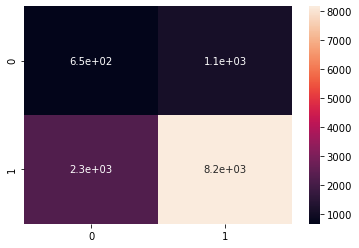

In [17]:
y_pred = model.predict(X_test)
print('F beta Score for both classes:')
print(fbeta_score(y_test, y_pred, beta = .1, average = 'weighted').round(2))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True);

Stacking doesn't improve the model, the opposite is true. So we finally stick with our random forest and logistic regression.

### 3.12 Conclusion

Our best models are 
 * a logistic regression model with a F beta score of .81 (with great weight on precision with beta = .1). The model parameters are:
   * C = 0.1
   * class weight = {0: 0.5, 1: 0.5}
   * regularization 
   * l1_ratio = 0, i.e., l2-regularization (Ridge)
   * maximum number of iterations: 7812
   
   
 * a random forest with a F beta score .81 with great weight on precision with beta = .1). The model parameters are:
   * number of estimators: 500, 
   * maximum number of features: sqrt
   * maximum depth: 8
   * criterion: Gini score
   * class weight: {0: 0.65, 1: 0.35} 
 
The best predictors to lean the decision for or against a borrower on are:
 * the funded amount
 * interest rate
 * borrower's grade
 * borrower's annual income
 * dept/ income ratio
 * the monthly payment owed by the borrower if the loan originates
 * the number of inquiries in past 6 months
 * the number of open credit lines in the borrower's credit file
 * the revolving line utilization rate
 * the total number of credit lines currently in the borrower's credit file 

This is good but since investors need to minimize their risk, the model needs further optimization. For instance, the possibilities of ensemble methods haven't been used exhaustively. Also, we could try a support vector machine model with a reduced dataset (since SVMs can't handle large datasets well). 
Additionally, feature selection is not ideal: intercorrelations between predictors are partly very high. This is acceptable, though, since we're not interested in the predictors' individual variance explanation but in a preferably good predicition of credit service.
